## Example 05 - Defining a basic simulation on a real graph

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# tranport network analysis package
import transport_network_analysis.core as core

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

# Graph location
location_graph = "Shape-Files/Rotterdam-Antwerpen-corridor"
name_graph = "edges_2.shp"

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

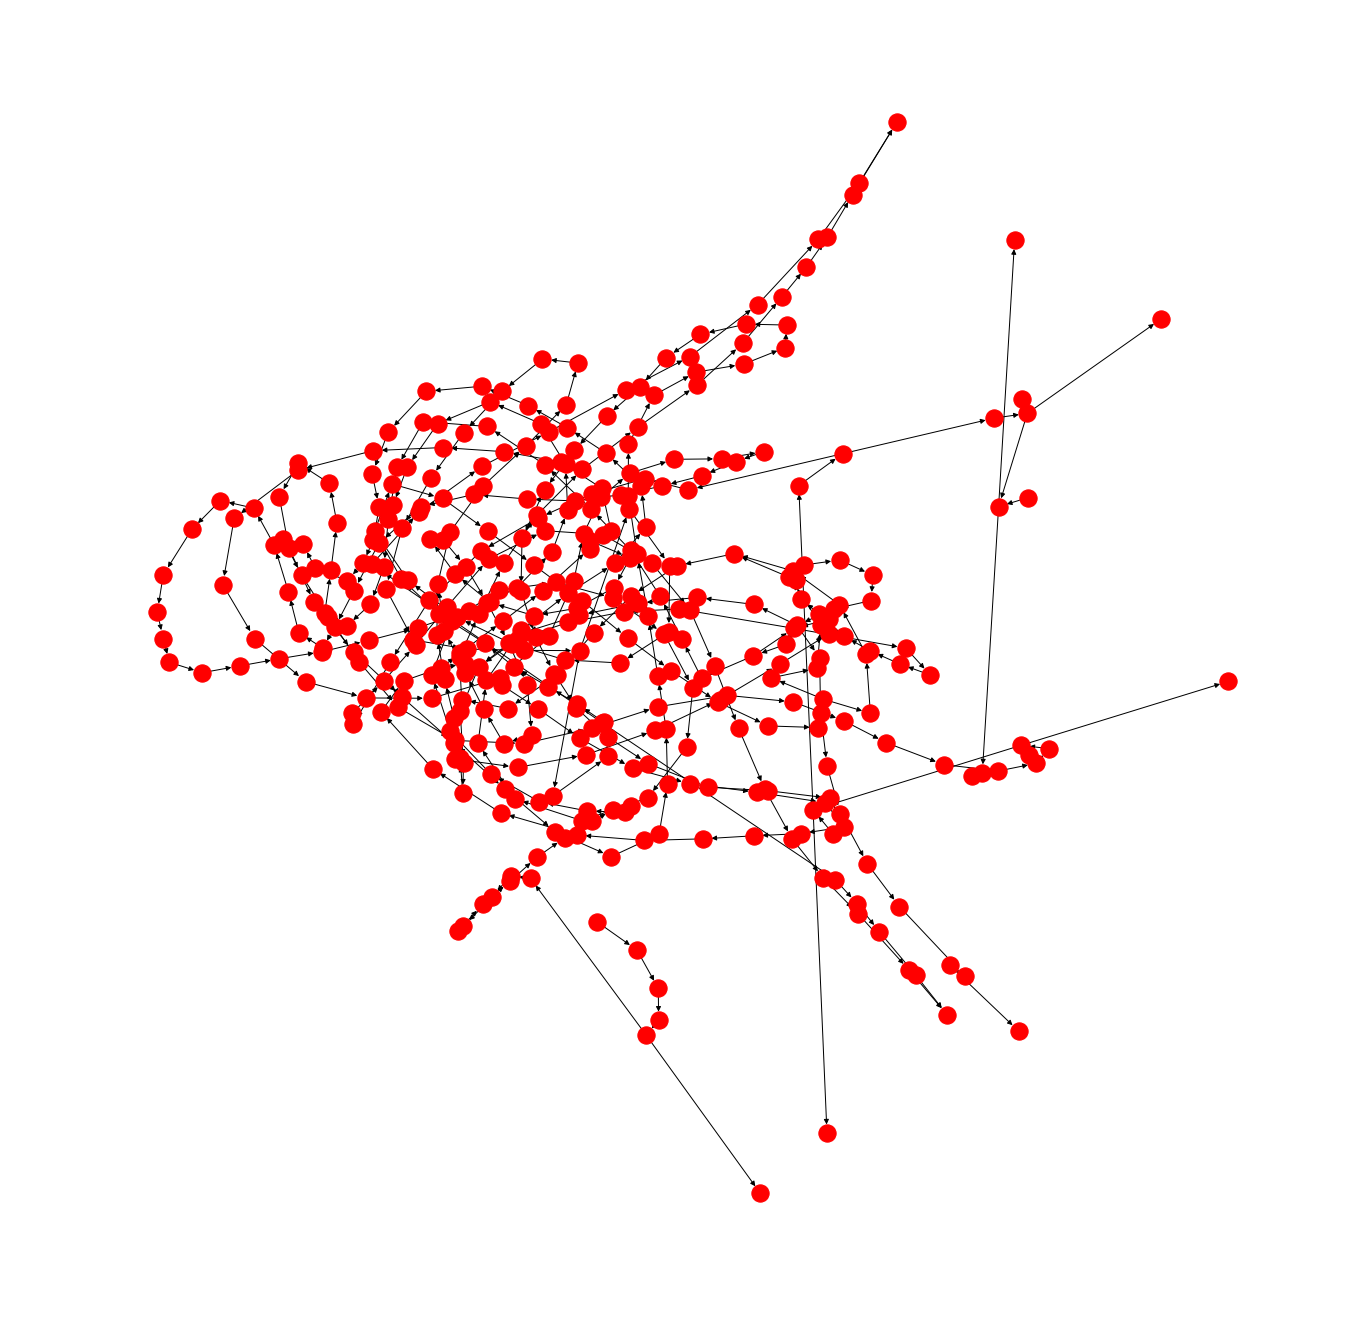

In [2]:
# Read the shape-file
FG = nx.read_shp(os.path.join(location_graph, name_graph), 
                 simplify=True)

# Draw the shape-file to get a first impression
plt.figure(figsize=(18,18))
nx.draw(FG)

# Show the drawing
plt.show()

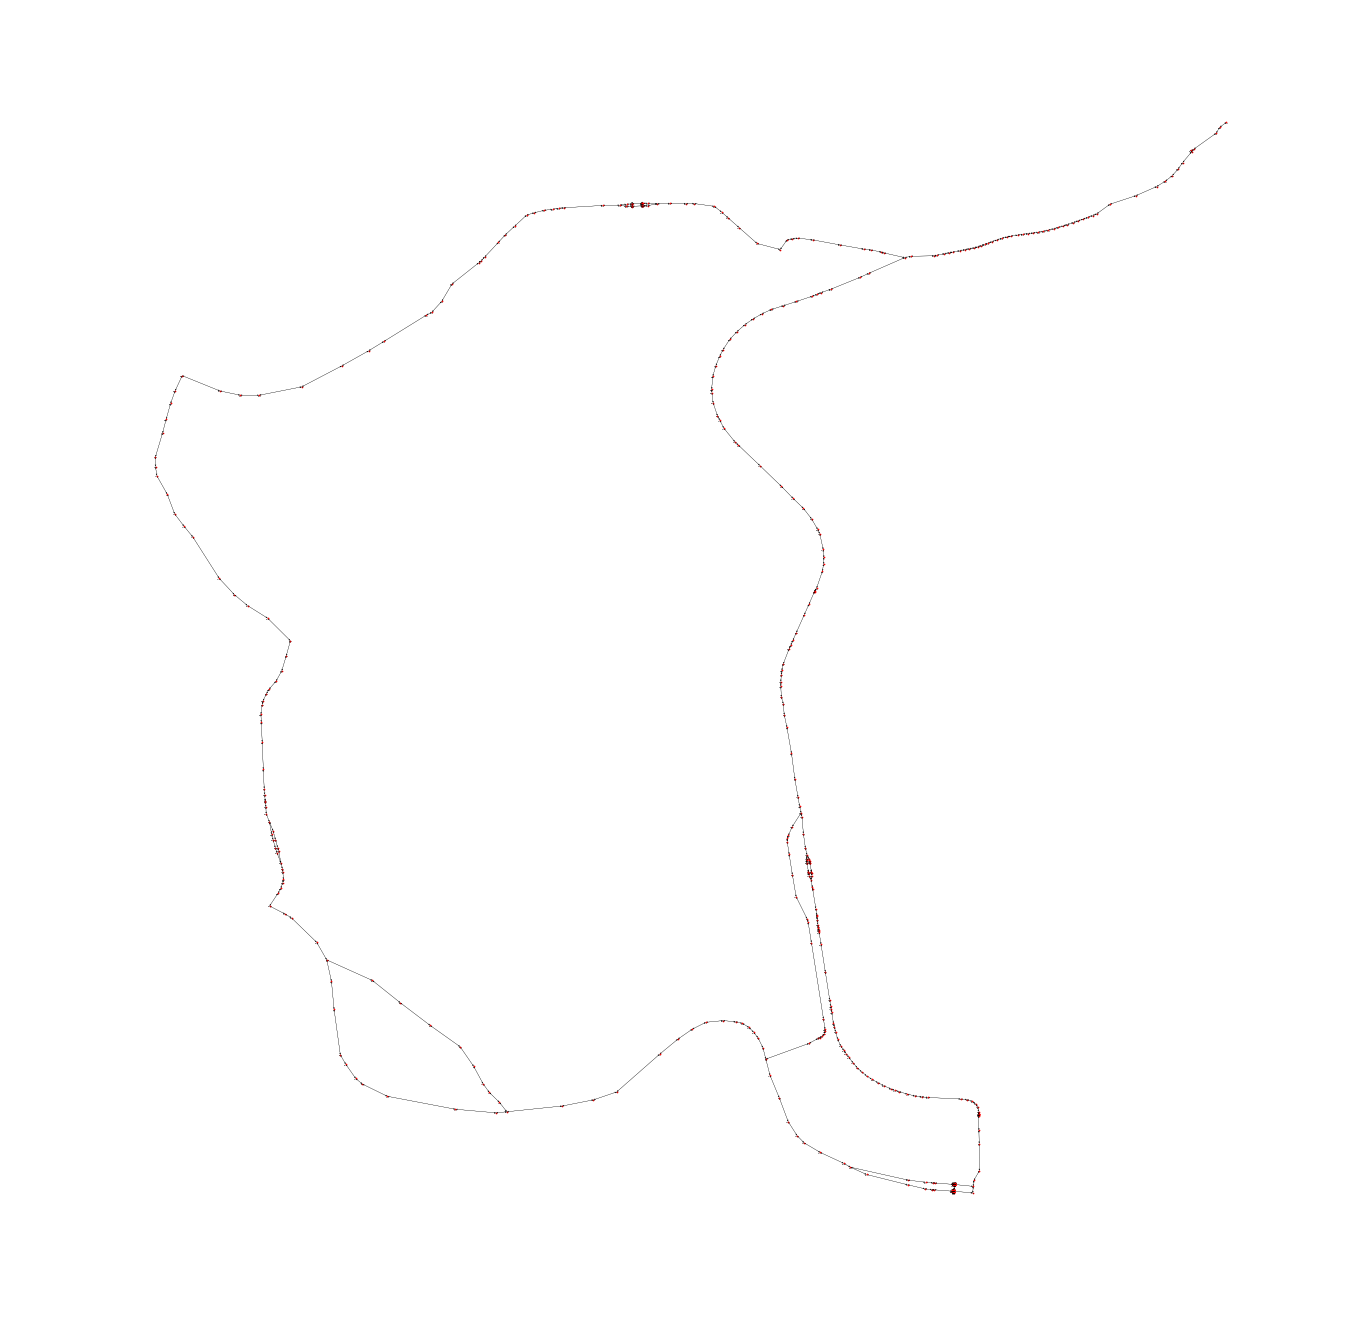

In [3]:
# calculate distance between two points
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                         shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2]
    
    return distance

H_G = nx.Graph()

lat_lon_to_index = {}
edge_id_counter = 0

for i, node in enumerate(FG.nodes(data = True)):
    H_G.add_node(i, pos = node[0], 
                    name = "Node {}".format(i),
                    geometry = shapely.geometry.Point(node[0][0], node[0][1]))
    lat_lon_to_index[node[0]] = i

    
for edge in FG.edges(data=True): 
    H_G.add_edge(lat_lon_to_index[edge[0]], 
                 lat_lon_to_index[edge[1]],
                 dis= calculate_distance(nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[1]]], 
                                         nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[0]]]))

FG = H_G.to_directed()
plt.figure(figsize=(18,18))
nx.draw(FG, nx.get_node_attributes(FG, 'pos'), with_labels=True, node_size=0.5, font_size = 2, width = 0.2, arrowsize = 3)
plt.show()

### Create vessels
Vessel without graph, but with shortest path.

In [4]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

# create the transport processing resource
vessel = TransportResource(**data_vessel)

### Define paths

In [5]:
# First simulation is from random node 1 to random node 2
random_1 = random.choice(list(FG))
random_2 = random.choice(list(FG))

path_1 = nx.dijkstra_path(FG, random_1, random_2)
print(path_1)

[374, 357, 358, 9, 10, 11, 369, 370, 371, 376, 377, 321, 322, 323, 333, 334, 397, 398, 399, 196, 197, 198, 319, 368, 260, 261, 262, 311, 312, 390, 391, 392, 78, 77, 76, 339, 58, 57, 56, 381, 201, 200, 199, 406, 327, 326, 215, 214, 213, 362, 204, 203, 202, 408, 407, 299, 298, 297, 293, 292, 291, 355, 177, 176, 175, 212, 211, 8, 7, 6, 375, 5, 4, 3, 22, 21, 189, 361, 360, 149, 148, 147, 151, 188, 187, 385, 384, 142, 93, 92, 91, 186, 185, 283, 259, 258, 183, 182, 184, 394, 154, 155, 156, 216, 217, 218, 2, 1, 0, 62, 61, 60, 318, 129, 128, 127, 331, 330, 123, 122, 121, 192, 191, 190, 310, 135, 28, 27, 26, 126, 125, 124, 320, 351, 49, 48, 31]


In [6]:
# First simulation is from random node 1 to random node 2
random_1 = random.choice(list(FG))
random_2 = random.choice(list(FG))

path_2 = nx.dijkstra_path(FG, random_1, random_2)
print(path_2)

[226, 100, 101, 102, 314, 79, 80, 81, 94, 95, 96, 303, 74, 304, 315, 395, 383, 253, 254, 255, 88, 89, 90, 109, 287, 288, 289, 345, 152, 75, 15, 16, 17, 388, 244, 245, 193, 194, 195, 32, 33, 34, 246, 247, 52, 130, 131, 352, 305, 306, 307, 373, 353, 354, 277, 278, 279, 220, 221, 222, 273, 274, 103, 104, 105, 224, 63, 64, 65, 356, 340, 341, 342, 308, 309, 161, 162, 163, 325, 236, 235, 234, 167, 166, 165, 118, 117, 116, 296, 294, 295, 229, 230]


In [7]:
paths = [path_1, path_2]

### Run simulation

In [8]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [9]:
for path in enumerate(paths):
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())
    
    # Add graph to environment
    env.FG = FG
    
    # Add environment and path to the vessel
    vessel.env = env
    vessel.route = path[1]

    # Start the simulation
    env.process(start(env, vessel))
    env.run()

    print("Simulation of path {} took {} seconds".format(path[0] + 1, int(env.now)))

Origin POINT (0 0)
Destination POINT (4.341554 51.6563173)
Simulation of path 1 took 1559633806 seconds
Origin POINT (4.2542152 51.3809497)
Destination POINT (4.2906999 51.346221)
Simulation of path 2 took 1553906910 seconds


### Testing
With v = 1 the distance of a path should be equal to the simulation time.

If simulation time == distance of path, test succeeds.

In [10]:
for geo in vessel.log["Geometry"]:
    print(geo.x, geo.y)

0.0 0.0
4.341554 51.6563173
4.341554 51.6563173
4.3395662 51.6557615
4.3395662 51.6557615
4.3370664 51.6551089
4.3370664 51.6551089
4.3354169 51.6546741
4.3354169 51.6546741
4.3333886 51.6542016
4.3333886 51.6542016
4.3313977 51.653749
4.3313977 51.653749
4.3292687 51.653322
4.3292687 51.653322
4.3272282 51.6529419
4.3272282 51.6529419
4.3251001 51.6526347
4.3251001 51.6526347
4.3229516 51.6524055
4.3229516 51.6524055
4.3208246 51.652197
4.3208246 51.652197
4.3187063 51.6519634
4.3187063 51.6519634
4.3165089 51.651734
4.3165089 51.651734
4.313727 51.651393
4.313727 51.651393
4.3122268 51.6511257
4.3122268 51.6511257
4.3100947 51.6507175
4.3100947 51.6507175
4.3079496 51.6501563
4.3079496 51.6501563
4.3059388 51.6495946
4.3059388 51.6495946
4.3042374 51.6490773
4.3042374 51.6490773
4.3028867 51.6486962
4.3028867 51.6486962
4.301646 51.6483537
4.301646 51.6483537
4.3000132 51.6479213
4.3000132 51.6479213
4.2987247 51.6476203
4.2987247 51.6476203
4.2966484 51.6473201
4.2966484 51.6473201


3.9650656 51.5924034
3.9650656 51.5924034
3.9669034 51.597486
3.9669034 51.597486


In [11]:
vessel.log["Timestamp"]

[datetime.datetime(2019, 3, 29, 11, 24, 56),
 datetime.datetime(2019, 6, 3, 22, 45, 47, 148371),
 datetime.datetime(2019, 6, 3, 22, 45, 47, 148371),
 datetime.datetime(2019, 6, 3, 22, 48, 17, 970548),
 datetime.datetime(2019, 6, 3, 22, 48, 17, 970548),
 datetime.datetime(2019, 6, 3, 22, 51, 25, 586510),
 datetime.datetime(2019, 6, 3, 22, 51, 25, 586510),
 datetime.datetime(2019, 6, 3, 22, 53, 29, 567411),
 datetime.datetime(2019, 6, 3, 22, 53, 29, 567411),
 datetime.datetime(2019, 6, 3, 22, 55, 59, 458435),
 datetime.datetime(2019, 6, 3, 22, 55, 59, 458435),
 datetime.datetime(2019, 6, 3, 22, 58, 26, 154991),
 datetime.datetime(2019, 6, 3, 22, 58, 26, 154991),
 datetime.datetime(2019, 6, 3, 23, 1, 0, 966434),
 datetime.datetime(2019, 6, 3, 23, 1, 0, 966434),
 datetime.datetime(2019, 6, 3, 23, 3, 28, 380781),
 datetime.datetime(2019, 6, 3, 23, 3, 28, 380781),
 datetime.datetime(2019, 6, 3, 23, 5, 59, 576440),
 datetime.datetime(2019, 6, 3, 23, 5, 59, 576440),
 datetime.datetime(2019, 6,

In [12]:
wgs84 = pyproj.Geod(ellps='WGS84')
distance_path_1 = 0
distance_path_2 = 0

for node in enumerate(path_1):
    orig = nx.get_node_attributes(FG, "geometry")[path_1[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_1[node[0] + 1]]

    distance_path_1 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_1):
                break

for node in enumerate(path_2):
    orig = nx.get_node_attributes(FG, "geometry")[path_2[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_2[node[0] + 1]]

    distance_path_2 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_2):
                break

In [13]:
distance_path_1, distance_path_2

(38991, 47143)